**Course**: Deep Learning

[<img align="right" width="400" height="100" src="https://www.tu-braunschweig.de/typo3conf/ext/tu_braunschweig/Resources/Public/Images/Logos/tu_braunschweig_logo.svg">](https://www.tu-braunschweig.de/en/) 

[Mehdi Maboudi](https://www.tu-braunschweig.de/en/igp/staff/mehdi-maboudi) \([m.maboudi@tu-bs.de](m.maboudi@tu-bs.de)) and [Pedro Achanccaray](https://www.tu-braunschweig.de/en/igp/staff/pedro-diaz) (p.diaz@tu-bs.de)

Submitted by: Arjun Arora \(a.arora@tu-braunschwieg.de) <p>
[Technical University of Braunschweig](https://www.tu-braunschweig.de/en/)  
[Institute of Geodesy and Photogrammetry](https://www.tu-braunschweig.de/igp) 

# Final Project: FloodNet: A High Resolution Aerial Imagery Dataset for Post Flood Scene Understanding code 

In this project, we will perform Image Classification on Floodnet dataset.
- Floodnet Dataset: FloodNet provides high-resolution UAS imageries with detailed semantic annotation and classified data.

- Image classificacation: This task aims at classifying images into set labels. It is a supervised learning path.

- Training data: The data is divided into "Flooded" and "Non-flooded" folders.

- Flooded labeled data contains 51 high resolution images, and 357 Non-Flooded images.

- We will make use of Transfer learning to train our model faster and cope with the low amount of training images.

- The evaluation measures are: classfication accuracy, precision, recall etc.

- Our notebook also provides a tensorboard that can be analysed to see the training trends.

https://arxiv.org/abs/2012.02951

Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adadelta, Adagrad, Adamax, Nadam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import to_categorical
# Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorboard import notebook
# Visualization
import matplotlib.pyplot as plt
import splitfolders
import tqdm, cv2, datetime

import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from os.path import join,basename
from glob import glob
from PIL import Image
import pandas as pd
import datetime, os

%load_ext tensorboard

Data preparation:
- First resize the images (reference: https://github.com/sahilkhose/FloodNet/blob/main/FloodNet_T1.ipynb)
- Split the train folder to train,test,and val

In [ ]:
# Resize the train flooded and non flooded folders from (4000,3000) to (400,300)
RESIZE=(400,300)
temp_root = "Labeled" 
local_root = "output_reshaped"

def resize_and_save(path, resize=RESIZE):
  for img_name in tqdm(os.listdir(os.path.join(temp_root, path))):
    img = cv2.imread(os.path.join(temp_root, path, img_name))
    img = cv2.resize(img, RESIZE)
    cv2.imwrite(os.path.join(local_root, path, img_name), img)

In [ ]:
# %cp -r "/content/drive/MyDrive/FloodNet Challenge @ EARTHVISION 2021 - Track 1" "./FloodNet Challenge @ EARTHVISION 2021 - Track 1"
os.makedirs("output_reshaped/Train/Flooded/image", exist_ok=True)
os.makedirs("output_reshaped/Train/Non-Flooded/image", exist_ok=True)
os.makedirs("output_reshaped/Train/Unlabeled/image", exist_ok=True)

In [ ]:
resize_and_save("Train/Labeled/Flooded/image")
resize_and_save("Train/Labeled/Non-Flooded/image")
resize_and_save("Train/Unlabeled/image")

In [2]:
#Split the training images to val, train and test
rm -rf ./logs/

data_path = 'Reshaped'

splitfolders.ratio("Reshaped/Train/Labeled/", output="output_reshaped",
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False) # default values


Data Load:
- Create custom dataframes with filenames and labels
- Create image data generator objects


In [2]:
#Flooded dataset
data_path = 'output_reshaped'
train_flooded_root = data_path + '/train/Flooded'
train_flooded_files = [name for name in os.listdir(train_flooded_root)]

test_flooded_root = data_path + '/test_original/Flooded'
test_flooded_files = [name for name in os.listdir(test_flooded_root)]

val_flooded_root = data_path + '/val/Flooded'
val_flooded_files = [name for name in os.listdir(val_flooded_root)]

train_flooded_y = [1]*len(train_flooded_files)
test_flooded_y = [1]*len(test_flooded_files)
val_flooded_y = [1]*len(val_flooded_files)

In [3]:
train_flooded_df = pd.DataFrame()
train_flooded_df['filename'] = train_flooded_files
train_flooded_df['label'] = train_flooded_y

val_flooded_df = pd.DataFrame()
val_flooded_df['filename'] = val_flooded_files
val_flooded_df['label'] = val_flooded_y

test_flooded_df = pd.DataFrame()
test_flooded_df['filename'] = test_flooded_files
test_flooded_df['label'] = test_flooded_y



In [4]:
#Non-flooded dataset

train_non_flooded_root = data_path + '/train/Non-Flooded'
train_non_flooded_files = [name for name in os.listdir(train_non_flooded_root)]

test_non_flooded_root = data_path + '/test_original/Non-Flooded'
test_non_flooded_files = [name for name in os.listdir(test_non_flooded_root)]

val_non_flooded_root = data_path + '/val/Non-Flooded'
val_non_flooded_files = [name for name in os.listdir(val_non_flooded_root)]

train_non_flooded_y = [0]*len(train_non_flooded_files)
test_non_flooded_y = [0]*len(test_non_flooded_files)
val_non_flooded_y = [0]*len(val_non_flooded_files)

In [5]:
train_non_flooded_df = pd.DataFrame()
train_non_flooded_df['filename'] = train_non_flooded_files
train_non_flooded_df['label'] = train_non_flooded_y

val_non_flooded_df = pd.DataFrame()
val_non_flooded_df['filename'] = val_non_flooded_files
val_non_flooded_df['label'] = val_non_flooded_y

test_non_flooded_df = pd.DataFrame()
test_non_flooded_df['filename'] = test_non_flooded_files
test_non_flooded_df['label'] = test_non_flooded_y



In [6]:
#Combine the flooded&non-flooded data for train,val and test

df_train = pd.concat([train_flooded_df, train_non_flooded_df])
df_val = pd.concat([val_flooded_df, val_non_flooded_df])
df_test = pd.concat([test_flooded_df, test_non_flooded_df])

df_train['label'] = df_train['label'].astype(str)
df_test['label'] = df_test['label'].astype(str)
df_val['label'] = df_val['label'].astype(str)


In [7]:
df_train

,filename,label
0,7332.jpg,1
1,6615.jpg,1
2,7523.jpg,1
3,7331.jpg,1
4,6614.jpg,1
...,...,...
272,9925.jpg,0
273,8385.jpg,0
274,7049.jpg,0
275,9070.jpg,0


In [8]:
df_test

,filename,label
0,7325.jpg,1
1,7485.jpg,1
2,7587.jpg,1
3,7428.jpg,1
4,7463.jpg,1
5,7466.jpg,1
0,7050.jpg,0
1,8176.jpg,0
2,7867.jpg,0
3,8822.jpg,0


In [9]:
df_val

,filename,label
0,7330.jpg,1
1,6716.jpg,1
2,7488.jpg,1
3,8379.jpg,1
4,7317.jpg,1
0,8161.jpg,0
1,9724.jpg,0
2,8412.jpg,0
3,7046.jpg,0
4,6994.jpg,0


Load the dataframes into ImageDataGenerator objects

In [23]:
# reference: https://towardsdatascience.com/transfer-learning-for-image-classification-using-tensorflow-71c359b56673

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create the ImageDataGenerator object
train_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
) 
# Generate batches and augment the images
train_generator = train_datagen.flow_from_dataframe(
    dataframe = df_train,
    directory=data_path+'/train/',
    x_col='filename',
    y_col='label',
    class_mode='binary',
    target_size=(400, 300),
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe = df_val,
    directory=data_path+'/val/',
    x_col='filename',
    y_col='label',
    class_mode='binary',
    target_size=(400, 300),
)

Found 317 validated image filenames belonging to 2 classes.
Found 39 validated image filenames belonging to 2 classes.


### Train the model using Transfer learning:

- Use resnet50 with our modifications for training
- Use tensorboard callbacks
- Increase the number of epochs to get even more training accuracy
- Because the images have been reshaped, the training process is fastened without much loss in accuracy

In [30]:
from tensorflow.keras.applications import ResNet50

# Initialize the Pretrained Model
feature_extractor = ResNet50(weights='imagenet', 
                             input_shape=(400, 300, 3),
                             include_top=False)

# Set this parameter to make sure it's not being trained
feature_extractor.trainable = False

# Set the input layer
input_ = tf.keras.Input(shape=(400, 300, 3))

# Set the feature extractor layer
x = feature_extractor(input_, training=False)

# Set the pooling layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Set the final layer with sigmoid activation function
output_ = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Create the new model object
model = tf.keras.Model(input_, output_)

# Compile it
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

# Print The Summary of The Model
model.summary()

2022-09-14 23:48:52.075286: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-14 23:48:52.075905: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 400, 300, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 13, 10, 2048)      23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


In [31]:
# Actual training with tensorboard callbacks
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history = model.fit(train_generator, epochs=20, validation_data=val_generator, callbacks=[tensorboard_callback])


/Users/arjunarora/miniforge3/envs/tensorflow_m1/lib/python3.10/site-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/Users/arjunarora/miniforge3/envs/tensorflow_m1/lib/python3.10/site-packages/keras/preprocessing/image.py:1671: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20


2022-09-14 23:48:56.041541: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-09-14 23:48:57.975195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - ETA: 0s - loss: 0.3532 - accuracy: 0.8738

2022-09-14 23:49:08.457872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 17s 1s/step - loss: 0.3532 - accuracy: 0.8738 - val_loss: 0.2861 - val_accuracy: 0.8718
Epoch 2/20
10/10 [==============================] - 12s 1s/step - loss: 0.2620 - accuracy: 0.9054 - val_loss: 0.2483 - val_accuracy: 0.9744
Epoch 3/20
10/10 [==============================] - 12s 1s/step - loss: 0.2093 - accuracy: 0.9338 - val_loss: 0.2021 - val_accuracy: 0.9744
Epoch 4/20
10/10 [==============================] - 12s 1s/step - loss: 0.1970 - accuracy: 0.9432 - val_loss: 0.1605 - val_accuracy: 0.9744
Epoch 5/20
10/10 [==============================] - 12s 1s/step - loss: 0.1761 - accuracy: 0.9558 - val_loss: 0.1744 - val_accuracy: 0.9744
Epoch 6/20
10/10 [==============================] - 12s 1s/step - loss: 0.1718 - accuracy: 0.9495 - val_loss: 0.2067 - val_accuracy: 0.9744
Epoch 7/20
10/10 [==============================] - 12s 1s/step - loss: 0.1605 - accuracy: 0.9527 - val_loss: 0.1918 - val_accuracy: 0.9744
Epoch 8/20
10/10 [=============

In [34]:
notebook.display(port=6006, height=1000)


Selecting TensorBoard with logdir logs (started 12:25:45 ago; port 6006, pid 54463).


Predictions on Test data

In [36]:
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix

y_true = []
y_pred = []
for i in os.listdir('output_reshaped/test/'):
    img = Image.open('output_reshaped/test/' + i)
    img = img.resize((300, 400))
    img = np.array(img)
    img = np.expand_dims(img, 0)
    
    y_true = test_flooded_y + test_non_flooded_y
    y_pred.append(1 if model.predict(img) > 0.5 else 0)
    
print(classification_report(y_true, y_pred))
print()
print(confusion_matrix(y_true, y_pred))

1/1 [==============================] - 0s 21ms/step
              precision    recall  f1-score   support

           0       0.89      0.86      0.87        36
           1       0.29      0.33      0.31         6

    accuracy                           0.79        42
   macro avg       0.59      0.60      0.59        42
weighted avg       0.80      0.79      0.79        42


[[31  5]
 [ 4  2]]


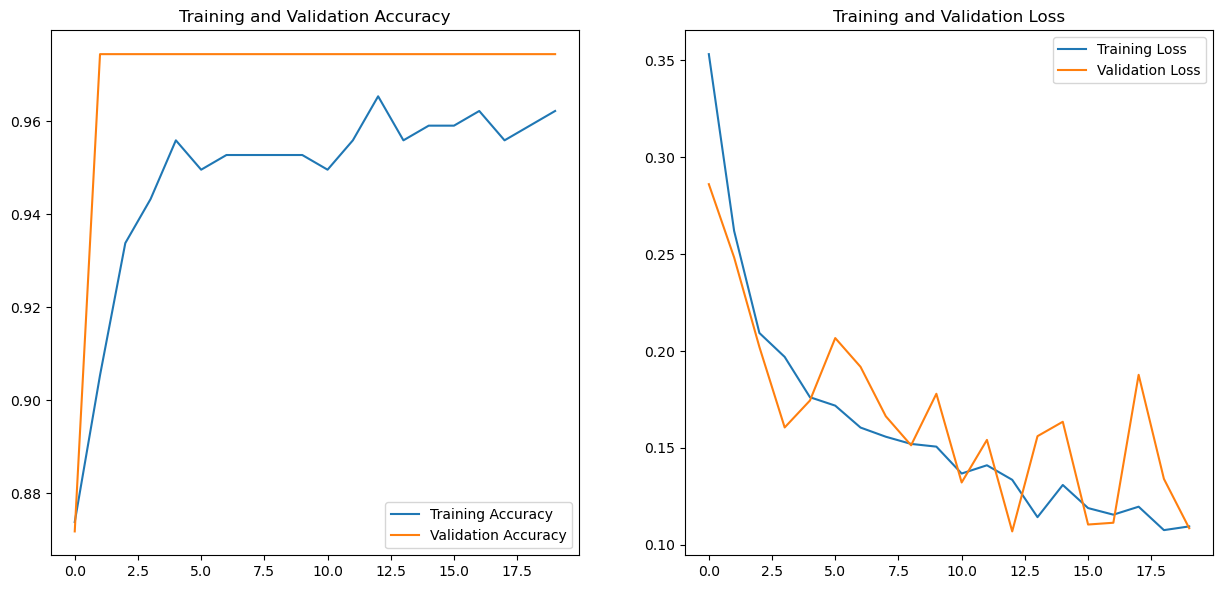

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()